# Python version - Supermodel - Nutrient Pulses

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

## Included N_pulse as a param

In [21]:
def dNdt(H, P, PH, N, parameters_dict):
    # Unpacking parameters
    r_H = parameters_dict['r_H']
    K_H = parameters_dict['K_H']
    theta_H = parameters_dict['theta_H']
    c = parameters_dict['c']
    d = parameters_dict['d']
    q_H = parameters_dict['q_H']
    E_H = parameters_dict['E_H']
    m_H = parameters_dict['m_H']
    r_P = parameters_dict['r_P']
    K_P = parameters_dict['K_P']
    b = parameters_dict['b']
    theta_P = parameters_dict['theta_P']
    q_P = parameters_dict['q_P']
    E_P = parameters_dict['E_P']
    m_P = parameters_dict['m_P']
    v_m = parameters_dict['v_m']
    k_s = parameters_dict['k_s']
    m_ph = parameters_dict['m_ph']
    y = parameters_dict['y']
    r_m = parameters_dict['r_m']
    kg = parameters_dict['kg']
    N_pulse = parameters_dict['N_pulse']


    # Calculate derivatives
    dH = r_H * H * (1 - H / K_H) + ((1 - y) * r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH))) * H) * (1 - H / K_H) - (
                c * H * P) / (d + H) + theta_H - (q_H * E_H * H) - (m_H * H)
    dP = r_P * P * (1 - P / K_P) + (b * H * P) / (d + H) + theta_P - q_P * E_P * P - m_P * P
    dPH = ((v_m * N * PH) / (k_s + N)) - (m_ph * PH) - ((r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H)
    dN = -(PH * (v_m * N) / (k_s + N)) + (0.5 * m_ph * PH) + (0.5 * m_H * H) + (1 * y * (r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H) + (
                0.5 * m_P * P)

    return dH, dP, dPH, dN

In [22]:
# Function: numerical solver, 2nd order RK 

def RK2(H, P, PH, N, parameters_dict):
    H_init = H
    P_init = P
    PH_init = PH 
    N_init = N 
    
    dH1, dP1, dPH1, dN1 = dNdt(H, P, PH, N, parameters_dict)
    
    H1 = H + 0.5 * dH1 #* dt
    P1 = P + 0.5 * dP1 #* dt
    PH1 = PH + 0.5 * dPH1 #* dt
    N1 = N + 0.5 * dN1 #* dt
    
    dH2, dP2, dPH2, dN2 = dNdt(H1, P1, PH1, N1, parameters_dict)
    
    dH_ave = (dH1+dH2)/2 
    dP_ave = (dP1+dP2)/2
    dPH_ave = (dPH1+dPH2)/2
    dN_ave = (dN1+dN2)/2
    
    H = (H_init + dH_ave) #* dt #(include as another param)
    P = (P_init + dP_ave) #* dt
    PH = (PH_init + dPH_ave) #* dt 
    N = (N_init + dN_ave) #* dt
    
    if H < 0:
        H = 0 
        
    if P < 0:
        P = 0 
    
    if PH < 0:
        PH = 0 
        
    if N < 0:
        N = 0
        
    
    #Calculate harvest 
    q_H = parameters_dict['q_H'] #proportionality constant for herbivore harvest 
    E_H = parameters_dict['E_H'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    #Calculate grazing 
    r_m = parameters_dict['r_m'] # grazing of fish on phytoplankton
    kg = parameters_dict['kg']
    
    grazing = r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H
    
    return H, P, PH, N, herbivore_harvest, predator_harvest, grazing

In [23]:

def run_model(INIT_H, INIT_P, INIT_PH, INIT_N, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    PH_array = np.zeros(numyears+1)
    N_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    grazing_array = np.zeros(numyears+1)
    
    H_array[0] = INIT_H #Starting biomass of herbivore
    P_array[0] = INIT_P #Starting biomass of predator 
    PH_array[0] = INIT_PH #Starting biomass of phytoplankton
    N_array[0] = INIT_N #Starting biomass of nutrients
    H_harvest_array[0] = 0
    P_harvest_array[0] = 0
    grazing_array[0] = 0
  
    
    for i in np.arange(0,numyears):
        H_array[i+1], P_array[i+1], PH_array[i+1], N_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1], grazing_array[i+1], \
            = RK2(H_array[i], P_array[i], PH_array[i], N_array[i], parameters_dict)
        
        # Check if it's time to add a pulse of nutrients
        if (i + 1) % 30 == 0:
            N_pulse = parameters_dict['N_pulse']  # Define the magnitude of the nutrient pulse
            N_array[i + 1] += N_pulse  # Add the nutrient pulse
        
    
    return H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array

In [24]:
numyears = 36500 # number of years to run simulation

#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 50 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.4/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = (0.0/365) # Effort for herbivore harvest
m_H = (0.1/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.1/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.4/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = (0.0/365) # Effort for predator harvest
m_P = (0.01/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 1 # half saturation constant
m_ph = 0.03 # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 #1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
N_pulse = 1.0
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }

In [25]:
numyears = 36500 # number of years to run simulation 

H0 = 20
P0 = 5
PH0 = 1
N0 = 1

H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)

Text(0, 0.5, 'Nutrients Biomass')

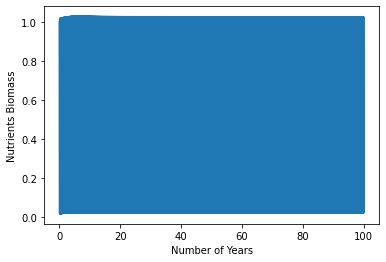

In [26]:
# Calculate the number of years in the simulation
numyears = parameters_dict['numyears']
years = numyears / 365

# Generate x-values representing years
time_years = np.linspace(0, years, len(H_array))

plt.plot(time_years, N_array)
plt.xlabel('Number of Years')
plt.ylabel('Nutrients Biomass')

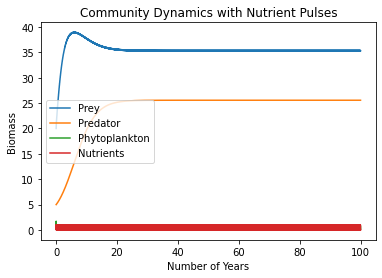

In [27]:
plt.plot(time_years, H_array, label="Prey")
plt.plot(time_years, P_array, label = "Predator")
plt.plot(time_years, PH_array, label= "Phytoplankton")
plt.plot(time_years, N_array, label= "Nutrients")
plt.legend()
plt.xlabel('Number of Years')
plt.ylabel('Biomass')
plt.title('Community Dynamics with Nutrient Pulses')

plt.show()

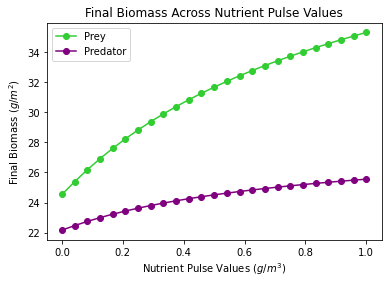

In [9]:
# Define the range of N_pulse_array values to plot
size = 25
N_pulse_array = np.linspace(0.0, 1.0, size)
N_final_array = np.zeros(size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)

for i, N_pulse in enumerate(N_pulse_array):
    parameters_dict['N_pulse'] = N_pulse
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    N_final_array[i] = np.mean(N_array[-3650:-1])
    H_final_array[i] = np.mean(H_array[-3650:-1])
    P_final_array[i] = np.mean(P_array[-3650:-1])

# Plot the final abundances
#plt.plot(N_pulse_array, N_final_array, label='Nutrients', color="red", marker="o")
plt.plot(N_pulse_array, H_final_array, label='Prey', color="limegreen", marker="o")
plt.plot(N_pulse_array, P_final_array, label='Predator', color="purple", marker="o")
plt.title('Final Biomass Across Nutrient Pulse Values')
plt.xlabel('Nutrient Pulse Values $(g/m^3)$')
plt.ylabel('Final Biomass $(g/m^2)$')
#plt.ylim(0,75)
plt.legend()

# Show the plot
plt.show()

In [19]:
print(P_final_array)

[14.09816629 14.15740118 14.21325115 14.26606491 14.31613927 14.36372908
 14.40905489 14.45230891 14.49365974 14.5332561  14.57122989 14.60769867
 14.64276764 14.67653138 14.70907522 14.74047642 14.77080515 14.80012537
 14.82849551 14.85596913 14.8825954  14.90841961 14.93348357 14.95782592
 14.98148249]


## Define Default Params Generalist

In [28]:
def default_generalist_params():
    numyears = 36500 # number of years to run simulation

    #Herbivore parameters:
    r_H = (0.4/365) # prey growth rate
    K_H = 50 # carrying capacity of herbivores
    theta_H = 0 # immigration of herbivores
    c = (0.2/365) # addition to predator from prey
    d = 50 # value of H when predation half its max value
    q_H = 1.0 # proportionality constant for herbivore harvest
    E_H = (0.0/365) # Effort for herbivore harvest
    m_H = (0.1/365) # Herbivore mortality 

    #Predator parameters:
    r_P = (0.1/365) # growth rate of predator 
    K_P = 10 # carrying capactiy of predators 
    b = (0.2/365) # mortality to prey from predator
    theta_P = 0 # immigration of predators  
    q_P = 1.0 # proportionality constant for predators harvest
    E_P = (0.0/365) # Effort for predator harvest
    m_P = (0.01/365) # Predator mortality

    #Phytoplankton parameters: 
    v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
    k_s = 1 # half saturation constant
    m_ph = 0.03 # phytoplankton mortality ## daily rate ?
    y = 0.1 # unassimilated phytoplankton 

    #Grazing parameters: 
    r_m = 1.1 #1.1 # grazing of fish on phytoplankton ## daily ??
    kg = 12
    N_pulse = 1.0
    # Timesteps
    dt = 0.1

    parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }
    
    return parameters_dict

## Define Default Params Specialist

In [29]:
def default_specialist_params():
    numyears = 36500 # number of years to run simulation

    #Herbivore parameters:
    r_H = (0.4/365) # prey growth rate
    K_H = 50 # carrying capacity of herbivores
    theta_H = 0 # immigration of herbivores
    c = (0.8/365) # addition to predator from prey
    d = 50 # value of H when predation half its max value
    q_H = 1.0 # proportionality constant for herbivore harvest
    E_H = (0.0/365) # Effort for herbivore harvest
    m_H = (0.1/365) # Herbivore mortality 

    #Predator parameters:
    r_P = (0.1/365) # growth rate of predator 
    K_P = 10 # carrying capactiy of predators 
    b = (0.8/365) # mortality to prey from predator
    theta_P = 0 # immigration of predators  
    q_P = 1.0 # proportionality constant for predators harvest
    E_P = (0.0/365) # Effort for predator harvest
    m_P = (0.01/365) # Predator mortality

    #Phytoplankton parameters: 
    v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
    k_s = 1 # half saturation constant
    m_ph = 0.03 # phytoplankton mortality ## daily rate ?
    y = 0.1 # unassimilated phytoplankton 

    #Grazing parameters: 
    r_m = 1.1 #1.1 # grazing of fish on phytoplankton ## daily ??
    kg = 12
    N_pulse = 1.0
    # Timesteps
    dt = 0.1

    parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }
    
    return parameters_dict

# Section 3

## Generalist Predator - Prey Harvest Curve - Low Nutrients

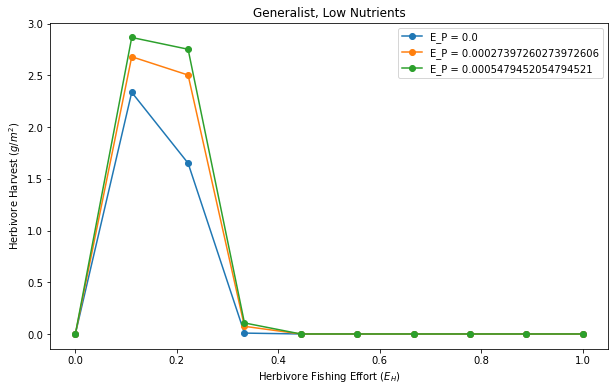

In [32]:
# Define parameters
N_pulse_value = 0.026
E_P_values = [(0.0/365), (0.1/365), (0.2/365)]
size = 10
E_H_array = np.linspace(0, 1.0, size)

# Initialize array to store results
H_harvest_final_array = np.zeros((len(E_P_values), size))

# Compute results for each E_P value
for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])

# Plot the results
plt.figure(figsize=(10, 6))

for idx, E_P in enumerate(E_P_values):
    plt.plot(E_H_array, H_harvest_final_array[idx]*365, label=f'E_P = {E_P}', marker="o")

plt.xlabel('Herbivore Fishing Effort ($E_H$)')
plt.ylabel('Herbivore Harvest ($g/m^2$)')
plt.title('Generalist, Low Nutrients')
plt.legend()
plt.show()

## Specialist - Prey Harvest - Low Nutrients

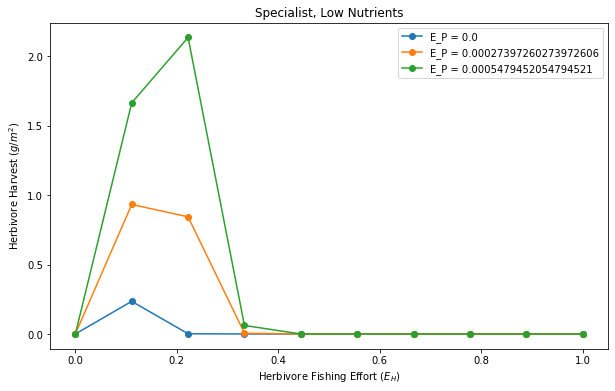

In [33]:
# Define parameters
N_pulse_value = 0.026
E_P_values = [(0.0/365), (0.1/365), (0.2/365)]
size = 10
E_H_array = np.linspace(0, 1.0, size)

# Initialize array to store results
H_harvest_final_array = np.zeros((len(E_P_values), size))

# Compute results for each E_P value
for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])

# Plot the results
plt.figure(figsize=(10, 6))

for idx, E_P in enumerate(E_P_values):
    plt.plot(E_H_array, H_harvest_final_array[idx]*365, label=f'E_P = {E_P}', marker="o")

plt.xlabel('Herbivore Fishing Effort ($E_H$)')
plt.ylabel('Herbivore Harvest ($g/m^2$)')
plt.title('Specialist, Low Nutrients')
plt.legend()
plt.show()

## Generalist - Prey Harvest - High Nutrients

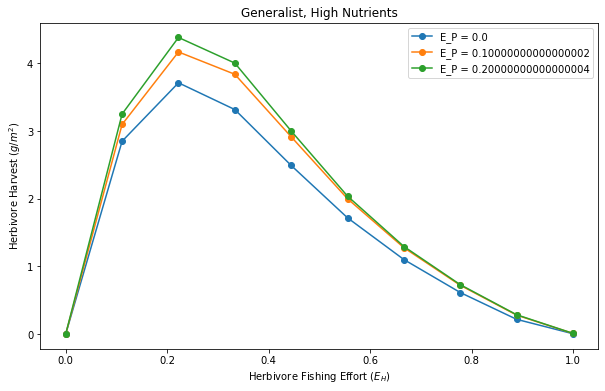

In [30]:
# Define parameters
N_pulse_value = 0.234
E_P_values = [(0.0/365), (0.1/365), (0.2/365)]
size = 10
E_H_array = np.linspace(0, 1.0, size)

# Initialize array to store results
H_harvest_final_array = np.zeros((len(E_P_values), size))

# Compute results for each E_P value
for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])

# Plot the results
plt.figure(figsize=(10, 6))

for idx, E_P in enumerate(E_P_values):
    plt.plot(E_H_array, H_harvest_final_array[idx]*365, label=f'E_P = {E_P*365}', marker="o")

plt.xlabel('Herbivore Fishing Effort ($E_H$)')
plt.ylabel('Herbivore Harvest ($g/m^2$)')
plt.title('Generalist, High Nutrients')
plt.legend()
plt.show()

## Specialist - Prey Harvest - High Nutrients

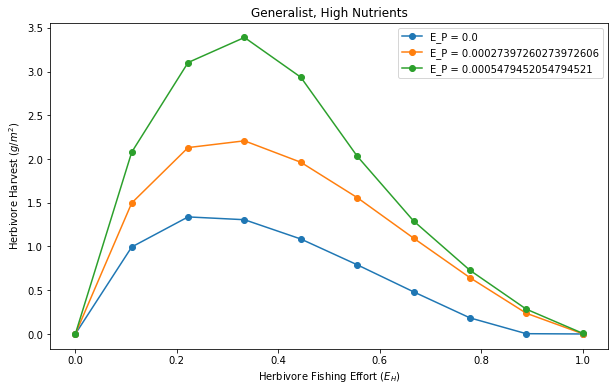

In [31]:
# Define parameters
N_pulse_value = 0.234
E_P_values = [(0.0/365), (0.1/365), (0.2/365)]
size = 10
E_H_array = np.linspace(0, 1.0, size)

# Initialize array to store results
H_harvest_final_array = np.zeros((len(E_P_values), size))

# Compute results for each E_P value
for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])

# Plot the results
plt.figure(figsize=(10, 6))

for idx, E_P in enumerate(E_P_values):
    plt.plot(E_H_array, H_harvest_final_array[idx]*365, label=f'E_P = {E_P}', marker="o")

plt.xlabel('Herbivore Fishing Effort ($E_H$)')
plt.ylabel('Herbivore Harvest ($g/m^2$)')
plt.title('Generalist, High Nutrients')
plt.legend()
plt.show()

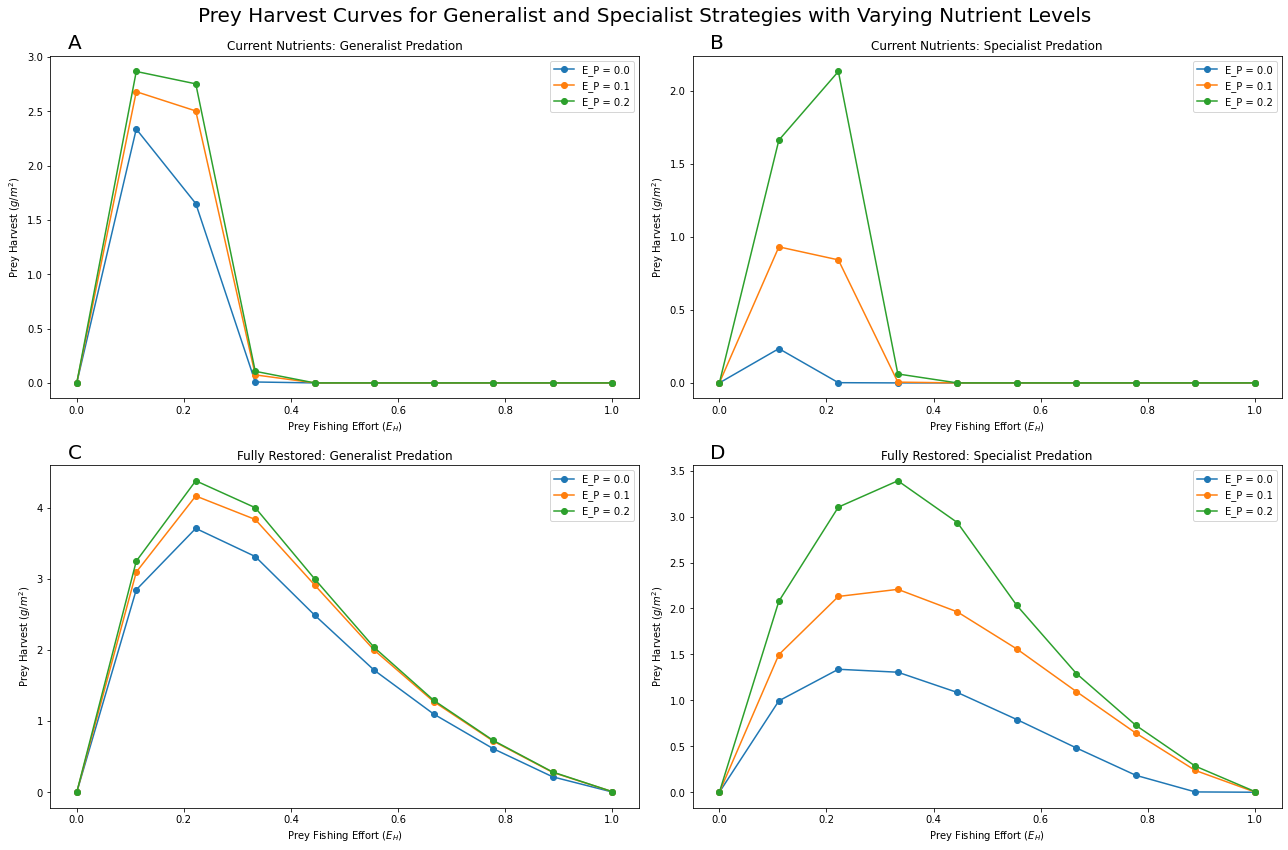

In [16]:
# Define the plotting function
def plot_harvest(E_H_array, H_harvest_final_array, E_P_values, title, ax, label):
    for idx, E_P in enumerate(E_P_values):
        ax.plot(E_H_array, H_harvest_final_array[idx]*365, label=f'E_P = {E_P*365:.1f}', marker="o")
    ax.set_xlabel('Prey Fishing Effort ($E_H$)')
    ax.set_ylabel('Prey Harvest ($g/m^2$)')
    ax.set_title(title)
    ax.legend()
    ax.text(0.03, 1.02, label, transform=ax.transAxes, fontsize=20)

# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Prey Harvest Curves for Generalist and Specialist Strategies with Varying Nutrient Levels', fontsize=20)

# Subplot 1: Generalist, Low Nutrients
N_pulse_value = 0.026
E_P_values = [(0.0/365), (0.1/365), (0.2/365)]
size = 10
E_H_array = np.linspace(0, 1.0, size)
H_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])

plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Current Nutrients: Generalist Predation', axes[0, 0], 'A')

# Subplot 2: Specialist, Low Nutrients
H_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])

plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Current Nutrients: Specialist Predation', axes[0, 1], 'B')

# Subplot 3: Generalist, High Nutrients
N_pulse_value = 0.234
H_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])

plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Fully Restored: Generalist Predation', axes[1, 0], 'C')

# Subplot 4: Specialist, High Nutrients
H_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])

plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Fully Restored: Specialist Predation', axes[1, 1], 'D')

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

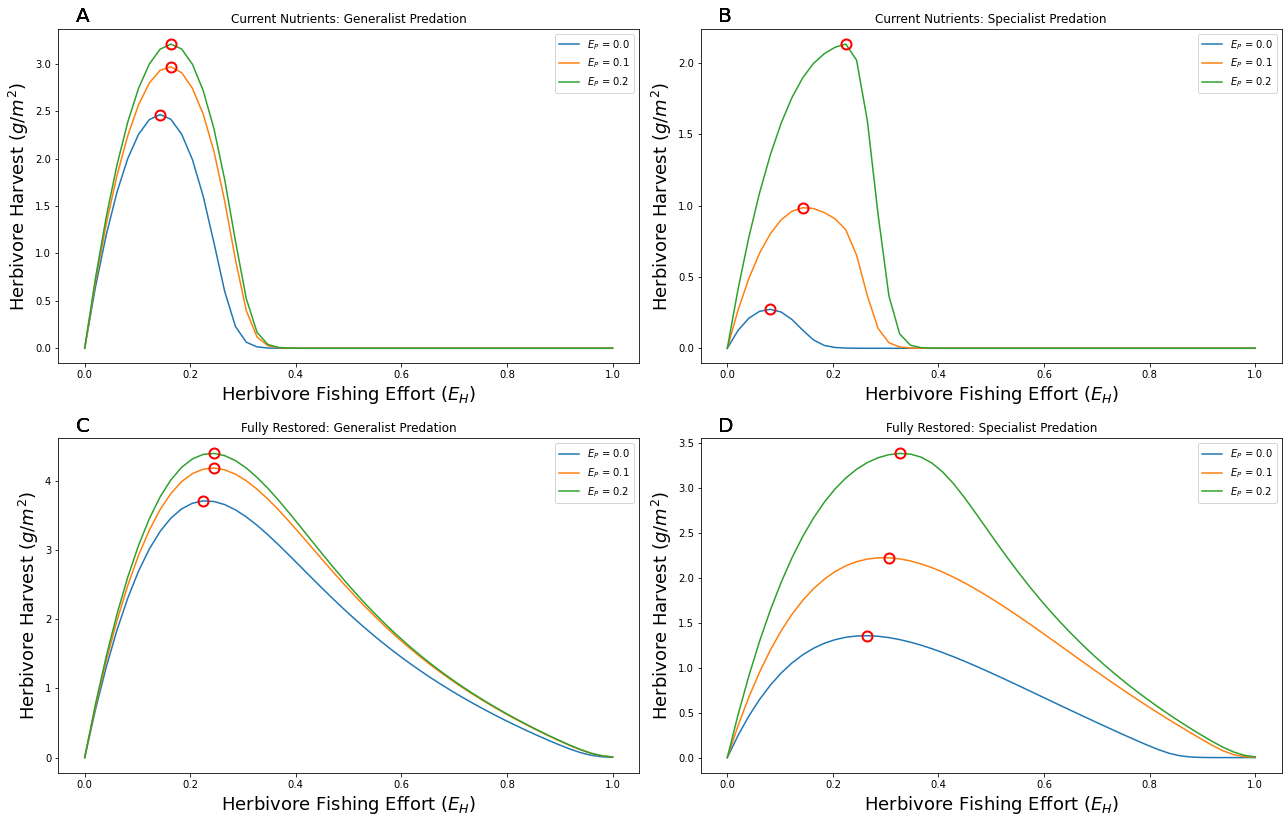

In [19]:
# Define the plotting function with maximum yield highlighting
def plot_harvest(E_H_array, H_harvest_final_array, E_P_values, title, ax, label):
    for idx, E_P in enumerate(E_P_values):
        y_values = H_harvest_final_array[idx] * 365
        ax.plot(E_H_array, y_values, label=f'$E_P$ = {E_P*365:.1f}')
        ax.text(0.03, 1.02, label, transform=ax.transAxes, fontsize=20)
        
        # Find the maximum value and its index
        max_idx = np.argmax(y_values)
        max_E_H = E_H_array[max_idx]
        max_value = y_values[max_idx]
        
        # Add a red circle around the maximum value
        ax.plot(max_E_H, max_value, 'ro', markersize=10, fillstyle='none', markeredgewidth=2)
        
    ax.set_xlabel('Herbivore Fishing Effort ($E_H$)', fontsize = 18)
    ax.set_ylabel('Herbivore Harvest ($g/m^2$)', fontsize = 18)
    ax.set_title(title)
    ax.legend()

# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
#fig.suptitle('Prey Harvest Curves for Generalist and Specialist Strategies with Varying Nutrient Levels', fontsize=20)

# Subplot 1: Generalist, Low Nutrients
N_pulse_value = 0.026
E_P_values = [(0.0/365), (0.1/365), (0.2/365)]
size = 50
E_H_array = np.linspace(0, 1.0, size)
H_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])

plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Current Nutrients: Generalist Predation', axes[0, 0], 'A')

# Subplot 2: Specialist, Low Nutrients
H_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])

plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Current Nutrients: Specialist Predation', axes[0, 1], 'B')

# Subplot 3: Generalist, High Nutrients
N_pulse_value = 0.234
H_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])

plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Fully Restored: Generalist Predation', axes[1, 0], 'C')

# Subplot 4: Specialist, High Nutrients
H_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])

plot_harvest(E_H_array, H_harvest_final_array, E_P_values, 'Fully Restored: Specialist Predation', axes[1, 1], 'D')

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Predator curves

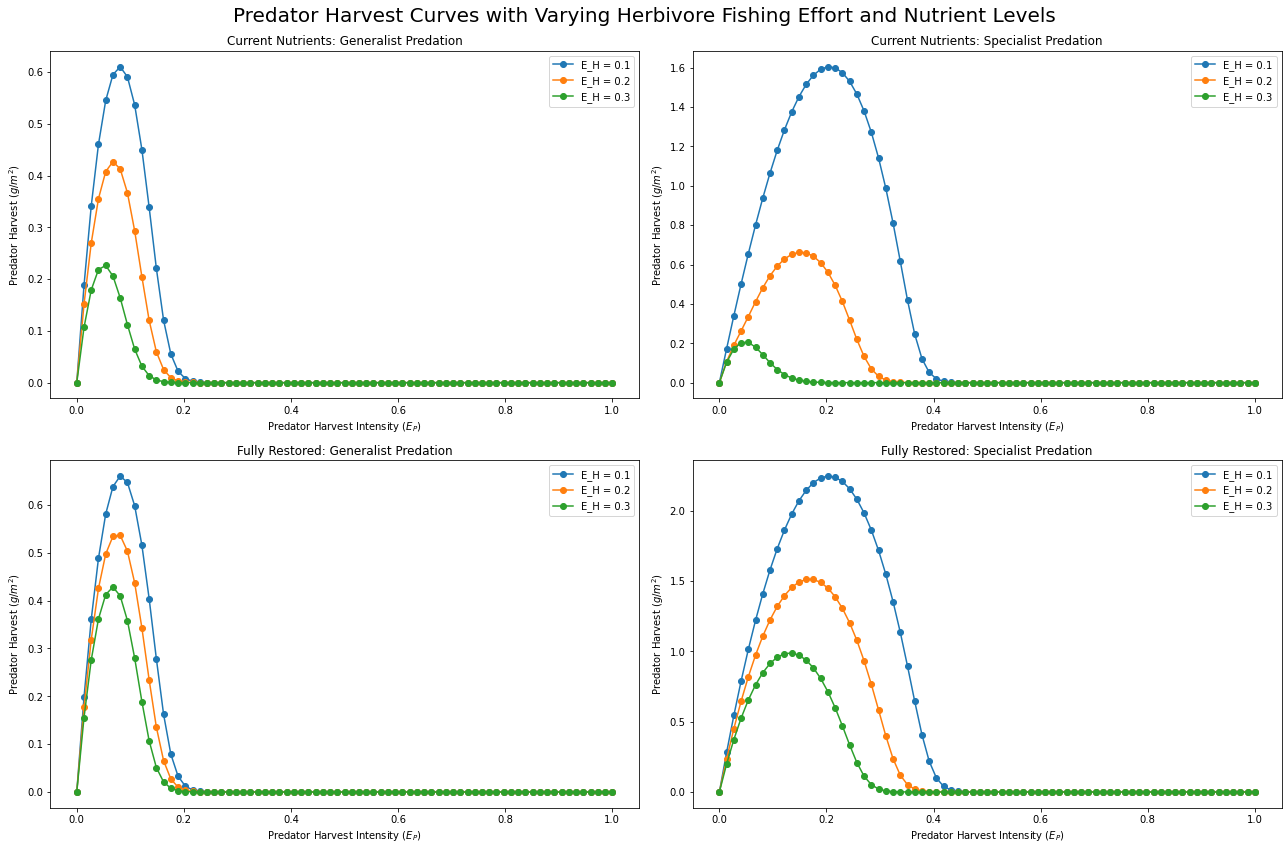

In [30]:
# Define the plotting function for predator harvest
def plot_predator_harvest(E_P_array, P_harvest_final_array, E_H_values, title, ax):
    for idx, E_H in enumerate(E_H_values):
        ax.plot(E_P_array, P_harvest_final_array[idx]*365, label=f'E_H = {E_H*365:.1f}', marker="o")
        
        # Find the maximum value and its index
        #max_idx = np.argmax(P_harvest_final_array[idx])
        #max_E_P = E_P_array[max_idx]
        #max_value = P_harvest_final_array[idx][max_idx]
        
        # Add a red circle around the maximum value
        #ax.plot(max_E_P*365, max_value, 'ro', markersize=10, fillstyle='none', markeredgewidth=2)
        
    ax.set_xlabel('Predator Harvest Intensity ($E_P$)')
    ax.set_ylabel('Predator Harvest ($g/m^2$)')
    ax.set_title(title)
    ax.legend()
    ax.set_ylim

# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Predator Harvest Curves with Varying Herbivore Fishing Effort and Nutrient Levels', fontsize=20)

# Subplot 1: Generalist, Low Nutrients
E_H_values = [0.1/365, 0.2/365, 0.3/365]
N_pulse_value = 0.026
size = 75
E_P_array = np.linspace(0, 1.0, size)
P_harvest_final_array = np.zeros((len(E_H_values), size))

for idx, E_H in enumerate(E_H_values):
    for i in range(size):
        E_P = E_P_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H
        parameters_dict['E_P'] = E_P / 365
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

plot_predator_harvest(E_P_array, P_harvest_final_array, E_H_values, 'Current Nutrients: Generalist Predation', axes[0, 0])

# Subplot 2: Specialist, Low Nutrients
P_harvest_final_array = np.zeros((len(E_H_values), size))

for idx, E_H in enumerate(E_H_values):
    for i in range(size):
        E_P = E_P_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H
        parameters_dict['E_P'] = E_P / 365
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

plot_predator_harvest(E_P_array, P_harvest_final_array, E_H_values, 'Current Nutrients: Specialist Predation', axes[0, 1])

# Subplot 3: Generalist, High Nutrients
N_pulse_value = 0.234
P_harvest_final_array = np.zeros((len(E_H_values), size))

for idx, E_H in enumerate(E_H_values):
    for i in range(size):
        E_P = E_P_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H
        parameters_dict['E_P'] = E_P / 365
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

plot_predator_harvest(E_P_array, P_harvest_final_array, E_H_values, 'Fully Restored: Generalist Predation', axes[1, 0])

# Subplot 4: Specialist, High Nutrients
P_harvest_final_array = np.zeros((len(E_H_values), size))

for idx, E_H in enumerate(E_H_values):
    for i in range(size):
        E_P = E_P_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H
        parameters_dict['E_P'] = E_P / 365
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

plot_predator_harvest(E_P_array, P_harvest_final_array, E_H_values, 'Fully Restored: Specialist Predation', axes[1, 1])

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

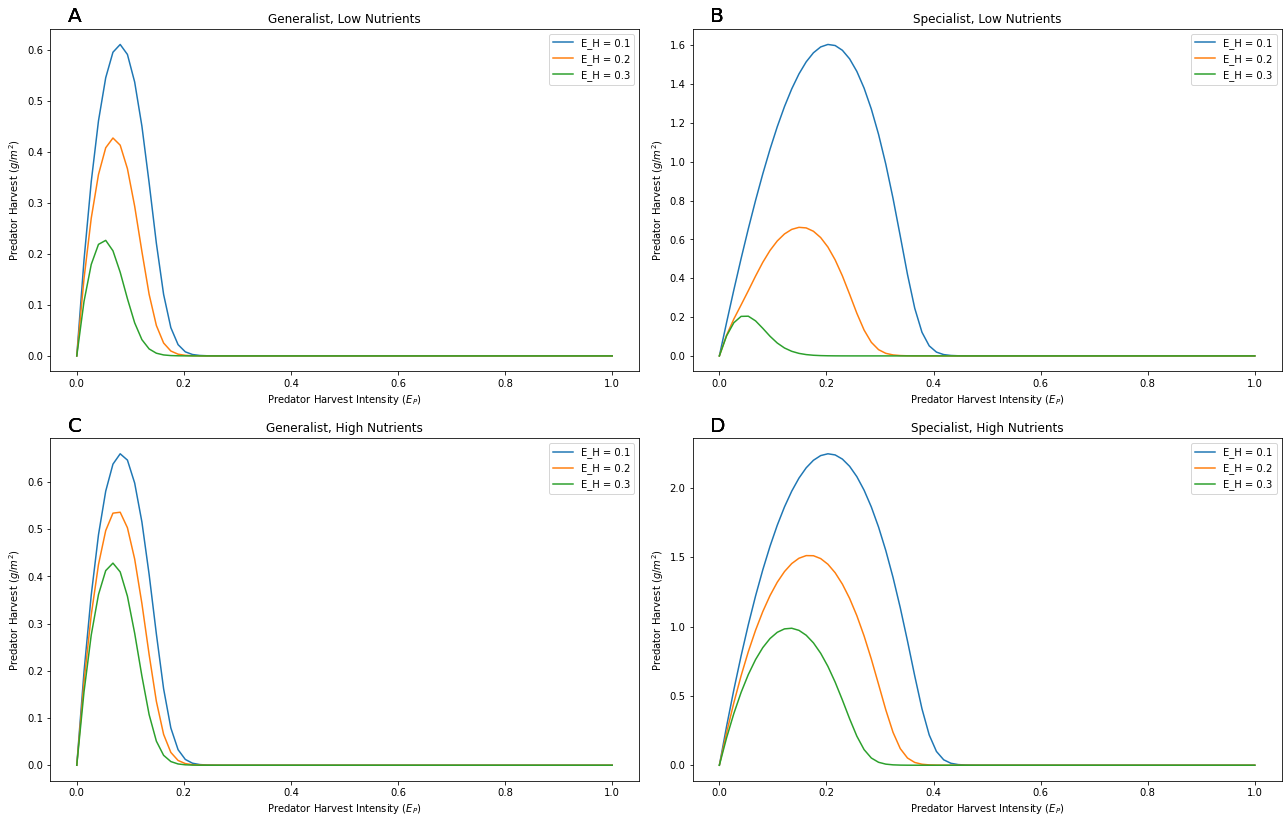

In [33]:
# Define the plotting function for predator harvest
def plot_predator_harvest(E_P_array, P_harvest_final_array, E_H_values, title, ax, label):
    for idx, E_H in enumerate(E_H_values):
        ax.plot(E_P_array, P_harvest_final_array[idx]*365, label=f'E_H = {E_H*365:.1f}')
        ax.text(0.03, 1.02, label, transform=ax.transAxes, fontsize=20)
        
        # Find the maximum value and its index
        #max_idx = np.argmax(P_harvest_final_array[idx])
        #max_E_P = E_P_array[max_idx]
        #max_value = P_harvest_final_array[idx][max_idx]
        
        # Add a red circle around the maximum value
        #ax.plot(max_E_P, max_value, 'ro', markersize=10, fillstyle='none', markeredgewidth=2)
        
    ax.set_xlabel('Predator Harvest Intensity ($E_P$)')
    ax.set_ylabel('Predator Harvest ($g/m^2$)')
    ax.set_title(title)
    ax.legend()
    ax.set_ylim

# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
#fig.suptitle('Predator Harvest Curves with Varying Herbivore Fishing Effort and Nutrient Levels', fontsize=20)

# Subplot 1: Generalist, Low Nutrients
E_H_values = [0.1/365, 0.2/365, 0.3/365]
N_pulse_value = 0.026
size = 75
E_P_array = np.linspace(0, 1.0, size)
P_harvest_final_array = np.zeros((len(E_H_values), size))

for idx, E_H in enumerate(E_H_values):
    for i in range(size):
        E_P = E_P_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H
        parameters_dict['E_P'] = E_P / 365
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

plot_predator_harvest(E_P_array, P_harvest_final_array, E_H_values, 'Generalist, Low Nutrients', axes[0, 0], 'A')

# Subplot 2: Specialist, Low Nutrients
P_harvest_final_array = np.zeros((len(E_H_values), size))

for idx, E_H in enumerate(E_H_values):
    for i in range(size):
        E_P = E_P_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H
        parameters_dict['E_P'] = E_P / 365
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

plot_predator_harvest(E_P_array, P_harvest_final_array, E_H_values, 'Specialist, Low Nutrients', axes[0, 1], 'B')

# Subplot 3: Generalist, High Nutrients
N_pulse_value = 0.234
P_harvest_final_array = np.zeros((len(E_H_values), size))

for idx, E_H in enumerate(E_H_values):
    for i in range(size):
        E_P = E_P_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H
        parameters_dict['E_P'] = E_P / 365
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

plot_predator_harvest(E_P_array, P_harvest_final_array, E_H_values, 'Generalist, High Nutrients', axes[1, 0], 'C')

# Subplot 4: Specialist, High Nutrients
P_harvest_final_array = np.zeros((len(E_H_values), size))

for idx, E_H in enumerate(E_H_values):
    for i in range(size):
        E_P = E_P_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H
        parameters_dict['E_P'] = E_P / 365
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

plot_predator_harvest(E_P_array, P_harvest_final_array, E_H_values, 'Specialist, High Nutrients', axes[1, 1], 'D')

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Maybe combine??

In [ ]:
# Define the plotting function for both herbivore and predator harvests
def plot_combined_harvest(E_H_array, H_harvest_final_array, P_harvest_final_array, E_P_values, title, ax):
    for idx, E_P in enumerate(E_P_values):
        # Plot Herbivore Harvest
        y_H_values = H_harvest_final_array[idx] * 365
        ax.plot(E_H_array, y_H_values, label=f'H_harvest E_P = {E_P*365:.1f}', marker="o", color='blue')
        
        # Plot Predator Harvest
        y_P_values = P_harvest_final_array[idx]
        ax.plot(E_H_array, y_P_values, label=f'P_harvest E_P = {E_P*365:.1f}', marker="s", linestyle='--', color='orange')
        
        # Find the maximum value and its index for Herbivore Harvest
        max_H_idx = np.argmax(y_H_values)
        max_E_H = E_H_array[max_H_idx]
        max_H_value = y_H_values[max_H_idx]
        
        # Add a red circle around the maximum value for Herbivore Harvest
        ax.plot(max_E_H, max_H_value, 'ro', markersize=10, fillstyle='none', markeredgewidth=2)

        # Find the maximum value and its index for Predator Harvest
        max_P_idx = np.argmax(y_P_values)
        max_P_E_H = E_H_array[max_P_idx]
        max_P_value = y_P_values[max_P_idx]
        
        # Add a green circle around the maximum value for Predator Harvest
        ax.plot(max_P_E_H, max_P_value, 'go', markersize=10, fillstyle='none', markeredgewidth=2)
        
    ax.set_xlabel('Herbivore Fishing Effort ($E_H$)')
    ax.set_ylabel('Harvest ($g/m^2$)')
    ax.set_title(title)
    ax.legend()

# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Harvest Curves with Varying Herbivore Fishing Effort and Nutrient Levels', fontsize=20)

# Subplot 1: Generalist, Low Nutrients
N_pulse_value = 0.026
E_P_values = [(0.0/365), (0.1/365), (0.2/365)]
size = 5
E_H_array = np.linspace(0, 1.0, size)
H_harvest_final_array = np.zeros((len(E_P_values), size))
P_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

plot_combined_harvest(E_H_array, H_harvest_final_array, P_harvest_final_array, E_P_values, 'Generalist, Current Nutrients', axes[0, 0])

# Subplot 2: Specialist, Low Nutrients
H_harvest_final_array = np.zeros((len(E_P_values), size))
P_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

plot_combined_harvest(E_H_array, H_harvest_final_array, P_harvest_final_array, E_P_values, 'Specialist, Current Nutrients', axes[0, 1])

# Subplot 3: Generalist, High Nutrients
N_pulse_value = 0.234
H_harvest_final_array = np.zeros((len(E_P_values), size))
P_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

plot_combined_harvest(E_H_array, H_harvest_final_array, P_harvest_final_array, E_P_values, 'Generalist, Restored Nutrients', axes[1, 0])

# Subplot 4: Specialist, High Nutrients
H_harvest_final_array = np.zeros((len(E_P_values), size))
P_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

plot_combined_harvest(E_H_array, H_harvest_final_array, P_harvest_final_array, E_P_values, 'Specialist, Restored Nutrients', axes[1, 1])

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

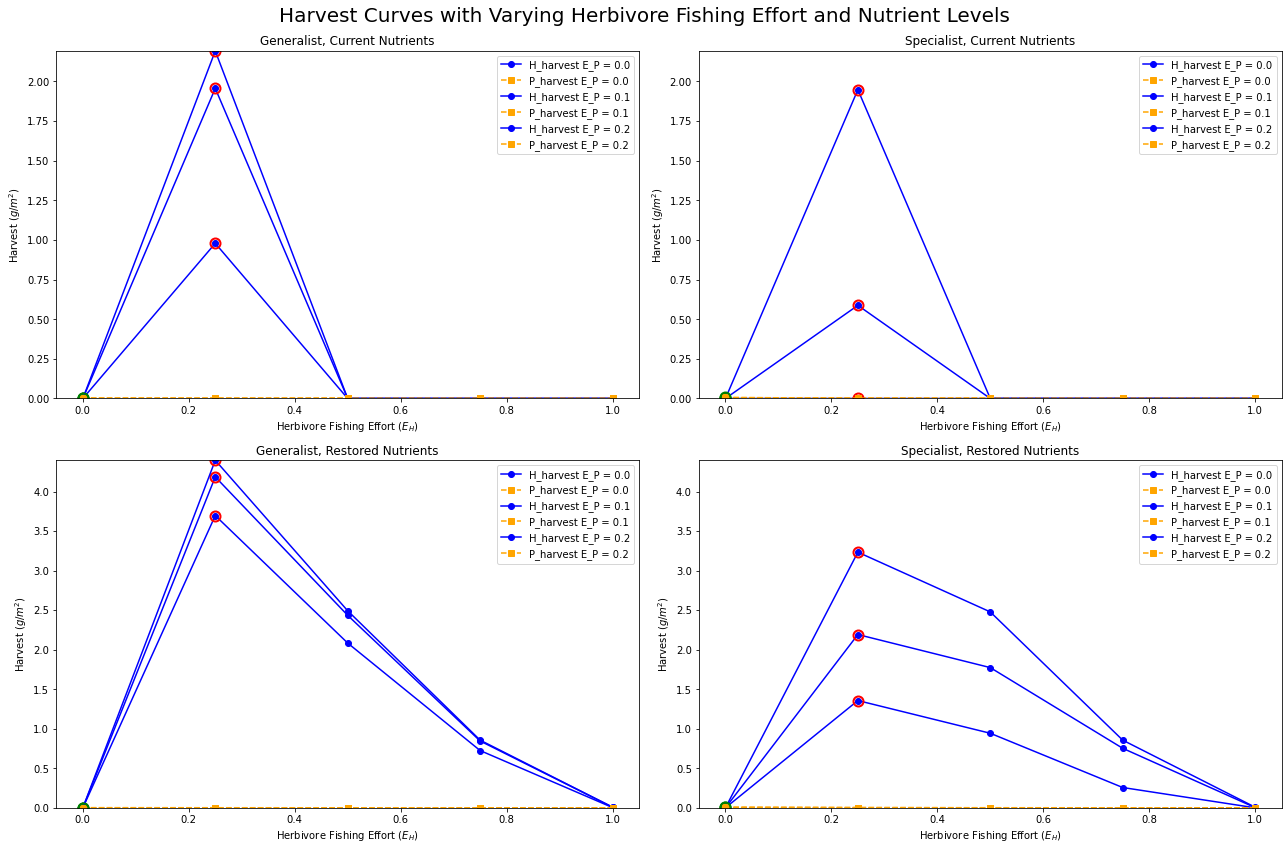

In [44]:
# Define the plotting function for both herbivore and predator harvests
def plot_combined_harvest(E_H_array, H_harvest_final_array, P_harvest_final_array, E_P_values, title, ax, y_lim):
    for idx, E_P in enumerate(E_P_values):
        # Plot Herbivore Harvest
        y_H_values = H_harvest_final_array[idx] * 365
        ax.plot(E_H_array, y_H_values, label=f'H_harvest E_P = {E_P*365:.1f}', marker="o", color='blue')
        
        # Plot Predator Harvest
        y_P_values = P_harvest_final_array[idx]
        ax.plot(E_H_array, y_P_values, label=f'P_harvest E_P = {E_P*365:.1f}', marker="s", linestyle='--', color='orange')
        
        # Find the maximum value and its index for Herbivore Harvest
        max_H_idx = np.argmax(y_H_values)
        max_E_H = E_H_array[max_H_idx]
        max_H_value = y_H_values[max_H_idx]
        
        # Add a red circle around the maximum value for Herbivore Harvest
        ax.plot(max_E_H, max_H_value, 'ro', markersize=10, fillstyle='none', markeredgewidth=2)

        # Find the maximum value and its index for Predator Harvest
        max_P_idx = np.argmax(y_P_values)
        max_P_E_H = E_H_array[max_P_idx]
        max_P_value = y_P_values[max_P_idx]
        
        # Add a green circle around the maximum value for Predator Harvest
        ax.plot(max_P_E_H, max_P_value, 'go', markersize=10, fillstyle='none', markeredgewidth=2)
        
    ax.set_xlabel('Herbivore Fishing Effort ($E_H$)')
    ax.set_ylabel('Harvest ($g/m^2$)')
    ax.set_title(title)
    ax.legend()
    ax.set_ylim(y_lim)  # Set common y-axis limit

# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Harvest Curves with Varying Herbivore Fishing Effort and Nutrient Levels', fontsize=20)

# Initialize lists to collect all y-values
all_y_values = []

# Calculate for Generalist, Low Nutrients
N_pulse_value = 0.026
E_P_values = [(0.0/365), (0.1/365), (0.2/365)]
size = 5
E_H_array = np.linspace(0, 1.0, size)
H_harvest_final_array = np.zeros((len(E_P_values), size))
P_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

    # Collect y-values for setting common limits
    all_y_values.extend(H_harvest_final_array[idx] * 365)
    all_y_values.extend(P_harvest_final_array[idx])

plot_combined_harvest(E_H_array, H_harvest_final_array, P_harvest_final_array, E_P_values, 'Generalist, Current Nutrients', axes[0, 0], y_lim=(min(all_y_values), max(all_y_values)))

# Calculate for Specialist, Low Nutrients
H_harvest_final_array = np.zeros((len(E_P_values), size))
P_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

    # Collect y-values for setting common limits
    all_y_values.extend(H_harvest_final_array[idx] * 365)
    all_y_values.extend(P_harvest_final_array[idx])

plot_combined_harvest(E_H_array, H_harvest_final_array, P_harvest_final_array, E_P_values, 'Specialist, Current Nutrients', axes[0, 1], y_lim=(min(all_y_values), max(all_y_values)))

# Calculate for Generalist, High Nutrients
N_pulse_value = 0.234
H_harvest_final_array = np.zeros((len(E_P_values), size))
P_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

    # Collect y-values for setting common limits
    all_y_values.extend(H_harvest_final_array[idx] * 365)
    all_y_values.extend(P_harvest_final_array[idx])

plot_combined_harvest(E_H_array, H_harvest_final_array, P_harvest_final_array, E_P_values, 'Generalist, Restored Nutrients', axes[1, 0], y_lim=(min(all_y_values), max(all_y_values)))

# Calculate for Specialist, High Nutrients
H_harvest_final_array = np.zeros((len(E_P_values), size))
P_harvest_final_array = np.zeros((len(E_P_values), size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

    # Collect y-values for setting common limits
    all_y_values.extend(H_harvest_final_array[idx] * 365)
    all_y_values.extend(P_harvest_final_array[idx])

plot_combined_harvest(E_H_array, H_harvest_final_array, P_harvest_final_array, E_P_values, 'Specialist, Restored Nutrients', axes[1, 1], y_lim=(min(all_y_values), max(all_y_values)))

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

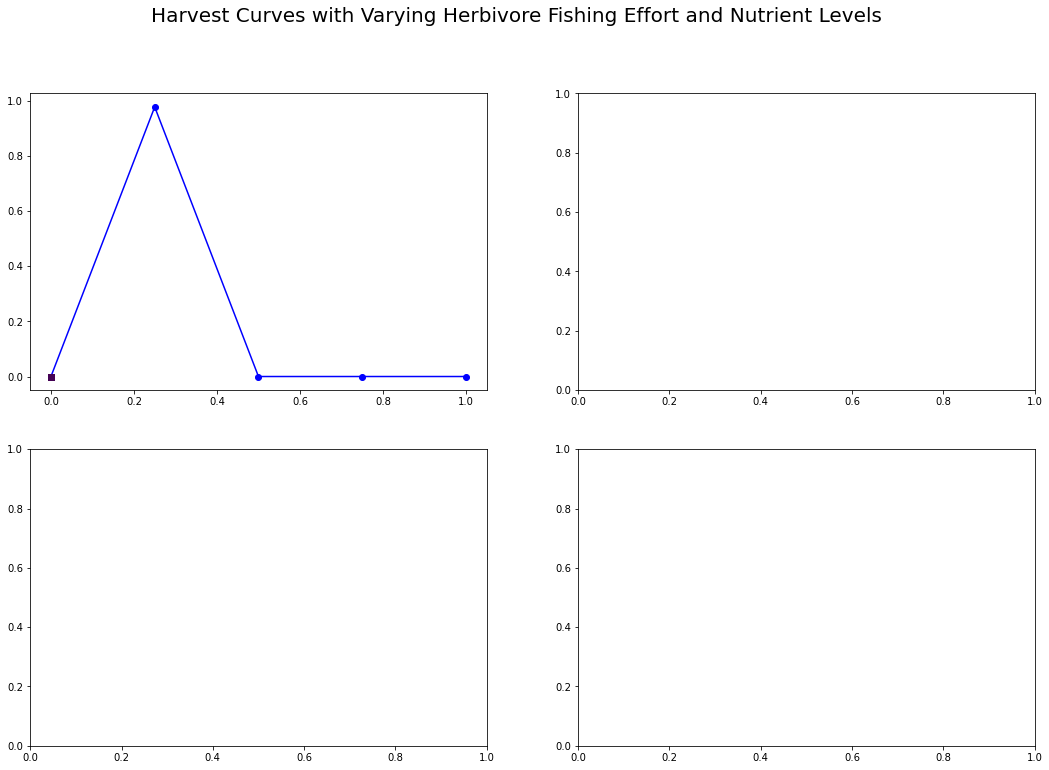

In [47]:
# Define the plotting function for both herbivore and predator harvests
def plot_combined_harvest(E_H_array, H_harvest_final_array, P_harvest_final_array, E_P_values, title, ax, y_lim):
    colors = cm.viridis(np.linspace(0, 1, len(E_H_array)))  # Create a colormap for E_H values

    for idx, E_P in enumerate(E_P_values):
        # Plot Herbivore Harvest
        y_H_values = H_harvest_final_array[idx] * 365
        ax.plot(E_H_array, y_H_values, label=f'H_harvest E_P = {E_P*365:.1f}', marker="o", color='blue')

        # Plot Predator Harvest with different colors for each E_H
        for i, E_H in enumerate(E_H_array):
            y_P_values = P_harvest_final_array[idx, i]
            ax.plot([E_H], [y_P_values], label=f'P_harvest E_H = {E_H:.1f}', marker="s", linestyle='--', color=colors[i])
            
            # Find the maximum value and its index for Predator Harvest
            max_P_idx = np.argmax(P_harvest_final_array[idx])
            max_P_E_H = E_H_array[max_P_idx]
            max_P_value = P_harvest_final_array[idx, max_P_idx]

            # Add a green circle around the maximum value for Predator Harvest
            ax.plot(max_P_E_H, max_P_value, 'go', markersize=10, fillstyle='none', markeredgewidth=2)

        # Find the maximum value and its index for Herbivore Harvest
        max_H_idx = np.argmax(y_H_values)
        max_E_H = E_H_array[max_H_idx]
        max_H_value = y_H_values[max_H_idx]

        # Add a red circle around the maximum value for Herbivore Harvest
        ax.plot(max_E_H, max_H_value, 'ro', markersize=10, fillstyle='none', markeredgewidth=2)

    ax.set_xlabel('Herbivore Fishing Effort ($E_H$)')
    ax.set_ylabel('Harvest ($g/m^2$)')
    ax.set_title(title)
    ax.legend()
    ax.set_ylim(y_lim)  # Set common y-axis limit

# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Harvest Curves with Varying Herbivore Fishing Effort and Nutrient Levels', fontsize=20)

# Initialize lists to collect all y-values
all_y_values = []

# Calculate for Generalist, Low Nutrients
N_pulse_value = 0.026
E_P_values = [(0.0/365), (0.1/365), (0.2/365)]
size = 5
E_H_array = np.linspace(0, 1.0, size)
H_harvest_final_array = np.zeros((len(E_P_values), size))
P_harvest_final_array = np.zeros((len(E_P_values), size, size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

    # Collect y-values for setting common limits
    all_y_values.extend(H_harvest_final_array[idx] * 365)
    all_y_values.extend(P_harvest_final_array[idx].flatten())

plot_combined_harvest(E_H_array, H_harvest_final_array, P_harvest_final_array, E_P_values, 'Generalist, Current Nutrients', axes[0, 0], y_lim=(min(all_y_values), max(all_y_values)))

# Calculate for Specialist, Low Nutrients
H_harvest_final_array = np.zeros((len(E_P_values), size))
P_harvest_final_array = np.zeros((len(E_P_values), size, size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

    # Collect y-values for setting common limits
    all_y_values.extend(H_harvest_final_array[idx] * 365)
    all_y_values.extend(P_harvest_final_array[idx].flatten())

plot_combined_harvest(E_H_array, H_harvest_final_array, P_harvest_final_array, E_P_values, 'Specialist, Current Nutrients', axes[0, 1], y_lim=(min(all_y_values), max(all_y_values)))

# Calculate for Generalist, High Nutrients
N_pulse_value = 0.234
H_harvest_final_array = np.zeros((len(E_P_values), size))
P_harvest_final_array = np.zeros((len(E_P_values), size, size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_generalist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

    # Collect y-values for setting common limits
    all_y_values.extend(H_harvest_final_array[idx] * 365)
    all_y_values.extend(P_harvest_final_array[idx].flatten())

plot_combined_harvest(E_H_array, H_harvest_final_array, P_harvest_final_array, E_P_values, 'Generalist, Restored Nutrients', axes[1, 0], y_lim=(min(all_y_values), max(all_y_values)))

# Calculate for Specialist, High Nutrients
H_harvest_final_array = np.zeros((len(E_P_values), size))
P_harvest_final_array = np.zeros((len(E_P_values), size, size))

for idx, E_P in enumerate(E_P_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_specialist_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['E_P'] = E_P
        parameters_dict['N_pulse'] = N_pulse_value  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

    # Collect y-values for setting common limits
    all_y_values.extend(H_harvest_final_array[idx] * 365)
    all_y_values.extend(P_harvest_final_array[idx].flatten())

plot_combined_harvest(E_H_array, H_harvest_final_array, P_harvest_final_array, E_P_values, 'Specialist, Restored Nutrients', axes[1, 1], y_lim=(min(all_y_values), max(all_y_values)))

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()